# Compare DMS to natural sequence evolution
The basic approach is to find all pairs of parent-descendant Pango clades that differ by at least one single spike amino-acid substitution, and then compare the differences in growth rates to changes in spike phenotypes measured by DMS.

This approach of comparing clade pairs is better than trying to compare all clades based on their phenotypes as it avoids phylogenetic correlations because it only utilizes the new mutation that has appeared in each parent / descendant clade pair rather than all mutations in clades (the latter approach is confounded by phylogeny due to clades sharing mutations by ancestry).

We compute P-values by comparing the actual correlations to those generated by randomizing the DMS data among mutations.

Note that at the end we also plot absolute predicted growth rate and DMS phenotypes for all clades, but do not perform regression on those due to phylogenetic issues noted above.

In [1]:
# this cell is tagged parameters for papermill parameterization
dms_summary_csv = None  # input DMS data
growth_rates_csv = None  # input growth rate data
pango_consensus_seqs_json = None  # Pango sequences
pair_growth_dms_csv = None  # output file with changes in growth versus changes in DMS for all clade pairs
clade_growth_dms_csv = None  # output file with growth and DMS phenotypes for clades
pair_min_spike_muts = None  # only keep pairs with at least this many mutations (typically 1)
pair_max_spike_muts = None  # only keep pairs with <= this many mutations, use None for no limit
split_by_rbd = None  # analyze RBD and non-RBD mutations separately
dms_clade = None  # starting DMS clade

In [2]:
# Parameters
starting_clades = ["XBB"]
muts_to_toggle = ["L455F"]
min_sequences = 400
split_by_rbd = False
dms_clade = "XBB.1.5"
pair_min_spike_muts = 1
pair_max_spike_muts = None
n_random = 100
phenotype_basic_colors = {
    "sera escape": "red",
    "ACE2 affinity": "blue",
    "cell entry": "purple",
}
exclude_clades = []
growth_rates_csv = "MultinomialLogisticGrowth/model_fits/rates.csv"
dms_summary_csv = "results/summaries/summary.csv"
pango_consensus_seqs_json = (
    "results/compare_natural/pango-consensus-sequences_summary.json"
)
pair_growth_dms_csv = "results/compare_natural/clade_pair_growth_dms.csv"
clade_growth_dms_csv = "results/compare_natural/clade_growth_dms.csv"

import os
os.chdir("../")

In [22]:
import collections
import datetime
import functools
import itertools
import json
import math
import operator
import re

import altair as alt

import Bio.Phylo

import matplotlib.pyplot as plt

import numpy

import pandas as pd

import polyclonal.plot

import scipy.stats

import statsmodels.api

_ = alt.data_transformers.disable_max_rows()

## Read Pango clades and identify all pairs and the separating spike mutations
First, read all Pango clades and get their new mutations relative to parents and to reference:

In [4]:
with open(pango_consensus_seqs_json) as f:
    pango_clades = json.load(f)

def build_records(c, recs):
    """Build records of Pango clade information."""
    if c in recs["clade"]:
        return
    recs["clade"].append(c)
    recs["date"].append(pango_clades[c]["designationDate"])
    recs["parent"].append(pango_clades[c]["parent"])
    recs["all_new_muts_from_ref"].append(
        [
            mut
            for field in ["aaSubstitutionsNew", "aaDeletionsNew"]
            for mut in pango_clades[c][field]
            if mut
        ]
    )
    recs["all_new_muts_reverted_from_ref"].append(
        [
            mut
            for field in ["aaSubstitutionsReverted", "aaDeletionsReverted"]
            for mut in pango_clades[c][field]
            if mut
        ]
    )
    recs["spike_muts_from_ref"].append(
        [
            mut.split(":")[1]
            for field in ["aaSubstitutions", "aaDeletions"]
            for mut in pango_clades[c][field]
            if mut and mut.startswith("S:")
        ]
    )
    for c_child in pango_clades[c]["children"]:
        build_records(c_child, recs)
        
records = collections.defaultdict(list)
for starting_clade in starting_clades:
    build_records(starting_clade, records)

pango_df = pd.DataFrame(records).query("clade not in @exclude_clades")

Now get all clade pairs and the spike differences between the parent and descendant clade.
Also note whether they have any additional non-spike mutations:

In [5]:
def consolidate_reversions(r):
    """If there are reversions, combine with new mutations to get actual changes."""
    reverted = r["all_new_muts_reverted_from_ref"]
    new = r["all_new_muts_from_ref"]
    if not reverted:
        return new
    # get as dicts with key: val of (gene, site): (wt, mutant)
    reverted_dict = {
        (m.split(":")[0], m.split(":")[1][1: -1]): (m.split(":")[1][0], m.split(":")[1][-1])
        for m in reverted
    }
    new_dict = {
        (m.split(":")[0], m.split(":")[1][1: -1]): (m.split(":")[1][0], m.split(":")[1][-1])
        for m in new
    }
    muts = []
    for (gene, site), (rev_wt, rev_mutant) in reverted_dict.items():
        if (gene, site) in new_dict:
            new_wt, new_mutant = new_dict[(gene, site)]
            muts.append(f"{gene}:{rev_mutant}{site}{new_mutant}")
            del new_dict[(gene, site)]
        else:
            muts.append(f"{gene}:{rev_mutant}{site}{rev_wt}")
    for (gene, site), (new_wt, new_mutant) in new_dict.items():
        muts.append(f"{gene}:{new_wt}{site}{new_mutant}")
    return muts

pango_pair_df = (
    pango_df
    .query("parent != ''")
    .assign(
        all_new_muts=lambda x: x.apply(consolidate_reversions, axis=1),
        spike_new_muts_list=lambda x: x["all_new_muts"].map(lambda ms: [m.split(":")[1] for m in ms if m[0] == "S"]),
        n_new_spike_muts=lambda x: x["spike_new_muts_list"].map(len),
        n_new_all_muts=lambda x: x["all_new_muts"].map(len),
    )
    .query("n_new_spike_muts >= @pair_min_spike_muts")
    .query("(n_new_spike_muts <= @pair_max_spike_muts) or (@pair_max_spike_muts == None)")
    .assign(
        spike_new_muts=lambda x: x["spike_new_muts_list"].map(lambda ms: "; ".join(ms)),
        nonspike_new_muts=lambda x: x["all_new_muts"].map(lambda ms: "; ".join(m for m in ms if not m.startswith("S:"))),
        only_new_muts_are_spike=lambda x: x["n_new_spike_muts"] == x["n_new_all_muts"],
    )
    [["clade", "parent", "date", "n_new_spike_muts", "spike_new_muts_list", "spike_new_muts", "nonspike_new_muts", "only_new_muts_are_spike"]]
    .reset_index(drop=True)
)

for mut in muts_to_toggle:
    pango_pair_df[f"has_{mut}"] = pango_pair_df["spike_new_muts_list"].map(lambda ms: mut in ms)

print("Number of clade pairs:")
display(
    pango_pair_df
    .groupby(["only_new_muts_are_spike", "n_new_spike_muts"])
    .aggregate(n_clade_pairs=pd.NamedAgg("clade", "count"))
)

Number of clade pairs:


n_clade_pairs
only_new_muts_are_spike n_new_spike_muts               
False                   1                           179
                        2                            38
                        3                             9
                        4                             2
                        5                             1
                        7                             1
True                    1                           186
                        2                            15
                        3                             3

## Assign changes in growth rate to Pango pair clades
For each pair clade, we compute the change in growth rate.

In [6]:
growth_rates = pd.read_csv(growth_rates_csv).rename(
    columns={"pango": "clade", "seq_volume": "n_sequences", "R": "growth_rate"}
)

if (invalid_clades := set(growth_rates["clade"]) - set(pango_clades)):
    raise ValueError(f"Growth rates specified for {invalid_clades}")

pango_pair_growth_df = (
    pango_pair_df
    .merge(growth_rates, on="clade", validate="one_to_one")
    .merge(
        growth_rates.rename(
            columns={
                "clade": "parent",
                "growth_rate": "parent_growth_rate",
                "n_sequences": "parent_n_sequences",
            }
        ),
        on="parent",
        validate="many_to_one",
    )
    .assign(change_in_growth_rate=lambda x: x["growth_rate"] - x["parent_growth_rate"])
)

print("Number of clade pairs with growth rates:")
display(
    pango_pair_growth_df
    .assign(
        **{
            f"at least {min_sequences} sequences": lambda x: (
                x[["n_sequences", "parent_n_sequences"]].min(axis=1) >= min_sequences
            )
        }
    )
    .groupby([f"at least {min_sequences} sequences", "only_new_muts_are_spike", "n_new_spike_muts"])
    .aggregate(n_clade_pairs=pd.NamedAgg("clade", "count"))
)

Number of clade pairs with growth rates:


n_clade_pairs
at least 400 sequences only_new_muts_are_spike n_new_spike_muts               
False                  False                   1                            20
                                               2                             3
                                               3                             1
                                               4                             1
                       True                    1                            31
True                   False                   1                            30
                                               2                             5
                                               3                             1
                       True                    1                            42
                                               2                             2

## Assign changes in DMS phenotypes to Pango clade pairs
For each clade pair, we compute the change in DMS phenotype.
Depending on value of `split_by_rbd` we split by whether mutation is (or is not) in RBD.

We also create randomized data frames for significance testing, where the DMS data are randomized among all mutations at sites that have measurements for all phenotypes.

In [7]:
# read the DMS data
dms_summary = pd.read_csv(dms_summary_csv).rename(
    columns={
        "spike mediated entry": "cell entry",
        "human sera escape": "sera escape",
    }
)

# DMS phenotypes of interest
phenotypes_basic = list(phenotype_basic_colors)
assert set(phenotypes_basic).issubset(dms_summary.columns), f"{phenotypes_basic=}\n{dms_summary.columns=}"

if split_by_rbd is False:
    phenotypes = phenotypes_basic
    phenotype_colors = phenotype_basic_colors
elif split_by_rbd is True:
    phenotypes = []
    phenotype_colors = {}
    for s in ["RBD", "non-RBD"]:
        for p in phenotypes_basic:
            p_by_rbd = f"{p} ({s})"
            phenotypes.append(p_by_rbd)
            phenotype_colors[p_by_rbd] = phenotype_basic_colors[p]
else:
    raise ValueError(f"invalid {split_by_rbd=}")

# dict that maps site to wildtype in DMS
dms_wt = dms_summary.set_index("site")["wildtype"].to_dict()

# dict that maps site to region in DMS
site_to_region = dms_summary.set_index("site")["region"].to_dict()

# dicts that maps (site, wt, mutant) to DMS phenotypes for mutations
dms_data_all_dict = (
    dms_summary
    .set_index(["site", "wildtype", "mutant"])
    [phenotypes_basic]
    .to_dict(orient="index")
)

# now make data frames with DMS data randomized for all sites of observed mutations
numpy.random.seed(0)
dms_summary_complete = dms_summary.query(" and ".join(f"`{p}`.notnull()" for p in phenotypes_basic))
dms_data_rand_dict = {
    i: pd.concat(
        [
            dms_summary_complete.drop(columns=phenotypes_basic).reset_index(drop=True),
            dms_summary_complete[phenotypes_basic].sample(frac=1).reset_index(drop=True),
        ],
        axis=1,
    ).set_index(["site", "wildtype", "mutant"])[phenotypes_basic].to_dict(orient="index")
    for i in range(n_random)
}

def mut_dms(m, dms_data_dict):
    """Get DMS phenotypes for a mutation."""
    null_d = {k: pd.NA for k in phenotypes_basic}
    site = int(m[1: -1])
    if site not in dms_wt:
        d = null_d
    else:
        parent = m[0]
        mut = m[-1]
        wt = dms_wt[site]
        if parent == wt:
            try:
                d = dms_data_dict[(site, parent, mut)]
            except KeyError:
                d = null_d
        elif mut == wt:
            try:
                d = {k: -v for (k, v) in dms_data_dict[(site, mut, parent)].items()}
            except KeyError:
                d = null_d
        else:
            try:
                parent_d = dms_data_dict[(site, wt, parent)]
                mut_d = dms_data_dict[(site, wt, mut)]
                d = {p: mut_d[p] - parent_d[p] for p in phenotypes_basic}
            except KeyError:
                d = null_d
    assert list(d) == phenotypes_basic
    return d

def muts_dms(ms, dms_data_dict):
    """Get DMS phenotypes for a list of mutations."""
    muts_d = {k: 0 for k in phenotypes}
    for m in ms:
        try:
            is_rbd = site_to_region[int(m[1: -1])] == "RBD"
        except KeyError:
            return {k: pd.NA for k in phenotypes}
        m_d = mut_dms(m, dms_data_dict)
        for k, val in m_d.items():
            if split_by_rbd:
                if is_rbd:
                    muts_d[f"{k} (RBD)"] += val
                else:
                    muts_d[f"{k} (non-RBD)"] += val
            else:
                muts_d[k] += val
    return muts_d

pango_pair_dms_growth_df = (
    pango_pair_growth_df
    # to add multiple columns: https://stackoverflow.com/a/46814360
    .apply(
        lambda cols: pd.concat(
            [cols, pd.Series(muts_dms(cols["spike_new_muts_list"], dms_data_all_dict))]
        ),
        axis=1,
    )
    .drop(columns="spike_new_muts_list")
    # remove any clade pairs for which we don't have DMS data for all phenotypes
    .query(" and ".join(f"`{p}`.notnull()" for p in phenotypes))
    .reset_index(drop=True)
)

# dataframe with randomized data
pango_pair_dms_growth_df_rand = pd.concat(
    [
        (
            pango_pair_growth_df
            # to add multiple columns: https://stackoverflow.com/a/46814360
            .apply(
                lambda cols: pd.concat(
                    [cols, pd.Series(muts_dms(cols["spike_new_muts_list"], d))]
                ),
                axis=1,
            )
            .drop(columns="spike_new_muts_list")
            # remove any clade pairs for which we don't have DMS data for all phenotypes
            .query(" and ".join(f"`{p}`.notnull()" for p in phenotypes))
            .reset_index(drop=True)
            .assign(randomization=i_random)
        )
        for (i_random, d) in dms_data_rand_dict.items()
    ],
    ignore_index=True,
)

print(f"Saving data to {pair_growth_dms_csv}")
pango_pair_dms_growth_df.to_csv(pair_growth_dms_csv, float_format="%.5g", index=False)

print("Number of clade pairs with DMS and growth data for all phenotypes:")
display(
    pango_pair_dms_growth_df
    .assign(
        **{
            f"at least {min_sequences} sequences": lambda x: (
                x[["n_sequences", "parent_n_sequences"]].min(axis=1) >= min_sequences
            )
        }
    )
    .groupby([f"at least {min_sequences} sequences", "only_new_muts_are_spike", "n_new_spike_muts"])
    .aggregate(n_clade_pairs=pd.NamedAgg("clade", "count"))
)

Saving data to results/compare_natural/clade_pair_growth_dms.csv
Number of clade pairs with DMS and growth data for all phenotypes:


n_clade_pairs
at least 400 sequences only_new_muts_are_spike n_new_spike_muts               
False                  False                   1                            17
                                               2                             3
                                               3                             1
                       True                    1                            29
True                   False                   1                            28
                                               2                             5
                                               3                             1
                       True                    1                            41
                                               2                             2

## Distribution of change in growth rates among clade pairs
Showing just clade pairs with DMS data and adequate sequences.

In [8]:
growth_change_df = (
    pango_pair_dms_growth_df
    .query("n_sequences >= @min_sequences")
    .query("parent_n_sequences >= @min_sequences")
    [["clade", "parent", "change_in_growth_rate"]]
)

growth_change_hist = (
    alt.Chart(growth_change_df)
    .encode(
        alt.X(
            "change_in_growth_rate",
            bin=alt.BinParams(),
            title="change in growth rate",
            axis=alt.Axis(labelFlush=False, labelOverlap=False),
        ),
        alt.Y("count()", title="number clade pairs"),
    )
    .mark_bar(color="gray")
    .configure_axis(grid=False)
    .properties(
        width=155,
        height=100,
    )
)

growth_change_hist

alt.Chart(...)

## Phenotype change correlations among clade pairs
Plot correlations between changes in DMS phenotype between all clade pairs.

In [9]:
clade_selection = alt.selection_point(fields=["clade"], on="mouseover", empty=False)

n_sequences_min = int(
    10 * math.log10(
        pango_pair_dms_growth_df[["n_sequences", "parent_n_sequences"]].min(axis=None)
    )
) / 10
n_sequences_slider = alt.param(
    value=math.log10(min_sequences),
    bind=alt.binding_range(
        name="min log10 number sequences in both clades",
        min=n_sequences_min,
        max=math.log10(pango_pair_dms_growth_df["n_sequences"].max() / 10),
        step=0.1,
    ),
)

only_new_muts_are_spike = alt.selection_point(
    fields=["only_new_muts_are_spike"],
    value=None,
    bind=alt.binding_radio(
        options=[True, False, None],
        labels=["only spike mutations", "spike & non-spike mutations", "either"],
        name="include clade pairs separated by",
    ),
)

toggle_muts = {
    mut: alt.selection_point(
        fields=[f"has_{mut}"],
        value=None,
        bind=alt.binding_radio(
            name=f"exclude clade pairs separated by {mut}",
            labels=["yes", "no"],
            options=[False, None],
        ),
    )
    for mut in muts_to_toggle
}

phenotype_scatter_base = (
    alt.Chart(pango_pair_dms_growth_df)
    .transform_calculate(
        min_n_sequences=alt.expr.min(
            alt.datum["n_sequences"], alt.datum["parent_n_sequences"]
        )
    )
    .transform_filter(
        alt.expr.log(alt.datum["min_n_sequences"]) / math.log(10) >= n_sequences_slider
    )
    .add_params(
        clade_selection,
        n_sequences_slider,
        only_new_muts_are_spike,
        *toggle_muts.values(),
    )
)

for toggle_filter in toggle_muts.values():
    phenotype_scatter_base = phenotype_scatter_base.transform_filter(toggle_filter)

tooltips = [
    "clade",
    "parent",
    "date",
    "spike_new_muts",
    "nonspike_new_muts",
    *[
        alt.Tooltip(p, format=".0f")
        for p in ["change_in_growth_rate", "growth_rate", "parent_growth_rate"]
    ],
    "n_sequences",
    "parent_n_sequences",
]

phenotype_scatter_charts = []
for pheno1, pheno2 in itertools.combinations(phenotypes, 2):
    if split_by_rbd:
        if pheno1.split()[-1] != pheno2.split()[-1]:
            continue
    phenotype_scatter_points = (
        phenotype_scatter_base
        .encode(
            alt.X(pheno1, scale=alt.Scale(nice=False, padding=5)),
            y=alt.Y(pheno2, scale=alt.Scale(nice=False, padding=5)),
            tooltip=[
                *[alt.Tooltip(p, format=".2f") for p in phenotypes],
                *tooltips,
            ],
            size=alt.condition(clade_selection, alt.value(70), alt.value(35)),
            strokeWidth=alt.condition(clade_selection, alt.value(2), alt.value(0.5)),
            stroke=alt.condition(clade_selection, alt.value("red"), alt.value("black")),
        )
        .mark_circle(fill="black", strokeOpacity=1, fillOpacity=0.35)
    )
    phenotype_scatter_r = (
        phenotype_scatter_base
        .transform_regression(pheno1, pheno2, params=True)
        .transform_calculate(
            r=alt.expr.if_(
                alt.datum["coef"][1] >= 0,
                alt.expr.sqrt(alt.datum["rSquared"]),
                -alt.expr.sqrt(alt.datum["rSquared"]),
            ),
            label='"r = " + format(datum.r, ".2f")',
        )
        .mark_text(align="left", color="purple", fontWeight=500, fontSize=11, opacity=1)
        .encode(x=alt.value(3), y=alt.value(7), text=alt.Text("label:N"))
        .properties(width=110, height=110)
    )
    phenotype_scatter_charts.append(phenotype_scatter_points + phenotype_scatter_r)

phenotype_scatter_chart = (
    alt.vconcat(
        *[
            alt.hconcat(*phenotype_scatter_charts[row * len(phenotypes_basic): (row + 1) * len(phenotypes_basic)])
            for row in range(int(math.ceil(len(phenotypes) / len(phenotypes_basic))))
        ],
        spacing=9,
    )
    .configure_axis(grid=False)
    .properties(        
        title=alt.TitleParams(
            "Changes in DMS phenotypes for mutations separating clade pairs",
            anchor="middle",
            fontSize=14,
            dy=-3,
        ),
    )    
)

phenotype_scatter_chart

alt.VConcatChart(...)

## Correlations between growth and phenotype changes for clade pairs
Correlations of growth rate versus change in each DMS phenotype for each clade pair:

In [10]:
pango_pair_dms_growth_df_tidy = pango_pair_dms_growth_df.melt(
    id_vars=[c for c in pango_pair_dms_growth_df.columns if c not in phenotypes],
    value_vars=phenotypes,
    var_name="phenotype_name",
    value_name="phenotype",
)

growth_phenotype_chart_size = 110

growth_phenotype_corr_base = (
    alt.Chart(pango_pair_dms_growth_df_tidy)
    .transform_calculate(
        min_n_sequences=alt.expr.min(
            alt.datum["n_sequences"], alt.datum["parent_n_sequences"]
        )
    )
    .transform_filter(
        alt.expr.log(alt.datum["min_n_sequences"]) / math.log(10) >= n_sequences_slider
    )
    .transform_filter(only_new_muts_are_spike)
    .add_params(
        clade_selection,
        n_sequences_slider,
        only_new_muts_are_spike,
        *toggle_muts.values(),
    )
    .properties(width=growth_phenotype_chart_size, height=growth_phenotype_chart_size)
)

for toggle_filter in toggle_muts.values():
    growth_phenotype_corr_base = growth_phenotype_corr_base.transform_filter(toggle_filter)

growth_phenotype_scatter = (
    growth_phenotype_corr_base
    .encode(
        alt.X(
            "change_in_growth_rate",
            title="change in growth",
            scale=alt.Scale(nice=False, padding=5),
        ),
        alt.Y("phenotype:Q", title=None, scale=alt.Scale(nice=False, padding=5)),
        alt.Fill(
            "phenotype_name:N",
            sort=phenotypes,
            legend=None,
            scale=alt.Scale(domain=phenotypes, range=list(phenotype_colors.values())),
        ),
        size=alt.condition(clade_selection, alt.value(70), alt.value(35)),
        strokeWidth=alt.condition(clade_selection, alt.value(2), alt.value(0.5)),
        tooltip=["phenotype_name:O", alt.Tooltip("phenotype:Q", format=".2f"), *tooltips],
    )
    .mark_circle(stroke="black", strokeOpacity=1, fillOpacity=0.45)
)

growth_phenotype_r = (
    growth_phenotype_corr_base
    .transform_regression("change_in_growth_rate", "phenotype", params=True)
    .transform_calculate(
        r=alt.expr.if_(
            alt.datum["coef"][1] >= 0,
            alt.expr.sqrt(alt.datum["rSquared"]),
            -alt.expr.sqrt(alt.datum["rSquared"]),
        ),
        label='"r = " + format(datum.r, ".2f")',
    )
    .mark_text(align="right", color="black", fontWeight=500, fontSize=11, opacity=1)
    .encode(
        x=alt.value(growth_phenotype_chart_size - 3),
        y=alt.value(growth_phenotype_chart_size - 5),
        text=alt.Text("label:N"),
    )
)

growth_phenotype_chart = (
    (growth_phenotype_scatter + growth_phenotype_r)
    .facet(
        facet=alt.Facet(
            "phenotype_name:O",
            sort=phenotypes,
            header=alt.Header(
                orient="left",
                labelFontStyle="bold",
                labelFontSize=11,
                labelPadding=2,
                title=None,
            ),
        ),
        spacing=8,
        columns=len(phenotypes_basic),
    )
    .properties(
        title=alt.TitleParams(
            "Changes in growth rate versus DMS phenotypes for clade pairs",
            anchor="middle",
            fontSize=14,
            dy=-3,
        ),
    )
    .resolve_scale(y="independent")
    .configure_axis(grid=False)
)

display(growth_phenotype_chart)

alt.FacetChart(...)

Also compute number of randomizations with correlations exceeding actual ones:

In [11]:
actual_corr = (
    pango_pair_dms_growth_df_tidy
    .query("(n_sequences >= @min_sequences) & (parent_n_sequences >= @min_sequences)")
    .groupby("phenotype_name")
    [["change_in_growth_rate", "phenotype"]]
    .corr()
    [["phenotype"]]
    .reset_index()
    .query("level_1 == 'change_in_growth_rate'")
    .drop(columns="level_1")
    .rename(columns={"phenotype": "corr_with_growth"})
)

rand_corrs = (
    pango_pair_dms_growth_df_rand
    .melt(
        id_vars=[c for c in pango_pair_dms_growth_df_rand.columns if c not in phenotypes],
        value_vars=phenotypes,
        var_name="phenotype_name",
        value_name="phenotype",
    )
    .query("(n_sequences >= @min_sequences) & (parent_n_sequences >= @min_sequences)")
    .groupby(["phenotype_name", "randomization"])
    [["change_in_growth_rate", "phenotype"]]
    .corr()
    [["phenotype"]]
    .reset_index()
    .query("level_2 == 'change_in_growth_rate'")
    .drop(columns="level_2")
    .rename(columns={"phenotype": "rand_corr_with_growth"})
)

corr_p = (
    actual_corr
    .merge(rand_corrs, on="phenotype_name", validate="one_to_many")
    .assign(ge=lambda x: x["rand_corr_with_growth"] >= x["corr_with_growth"])
    .groupby(["phenotype_name", "corr_with_growth"], as_index=False)
    .aggregate(
        n_rand=pd.NamedAgg("randomization", "count"),
        n_rand_ge_actual=pd.NamedAgg("ge", "sum"),
    )
    .assign(p=lambda x: x["n_rand_ge_actual"] / x["n_rand"])
)

corr_p

,phenotype_name,corr_with_growth,n_rand,n_rand_ge_actual,p
0,ACE2 affinity,0.210710,100,13,0.13
1,cell entry,0.458655,100,9,0.09
2,sera escape,0.637673,100,1,0.01


## Multiple least squares regression of changes growth versus DMS phenotypes for clade pairs
Regress change in growth rate for each clade pair versus change in DMS phenotypes.
Do this for several different options of mutations to toggle, etc.

We also show a P-values for the correlation exceeding that with the randomized DMS data in the plot title.

In [12]:
def powerset(iterable):
    # https://stackoverflow.com/a/1482316
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def ols_unique_var_explained(var_endog, vars, df, full_r2):
    """Get unique variance explained by fitting model after removing each variable.

    https://blog.minitab.com/en/adventures-in-statistics-2/how-to-identify-the-most-important-predictor-variables-in-regression-models
    
    """
    unique_var = {}
    for vremove in vars:
        vremove_ols_model = statsmodels.api.OLS(
            endog=df[[var_endog]],
            exog=statsmodels.api.add_constant(df[[v for v in vars if v != vremove]].astype(float)),
        )
        vremove_res_ols = vremove_ols_model.fit()
        unique_var[vremove] = full_r2 - vremove_res_ols.rsquared
    return unique_var

for only_new_muts_are_spike in [False]:
    ols_df1 = (
        pango_pair_dms_growth_df.query("only_new_muts_are_spike")
        if only_new_muts_are_spike
        else pango_pair_dms_growth_df.copy()
    )
    for muts_excluded in powerset(muts_to_toggle):
        print(f"\n{min_sequences=}, {only_new_muts_are_spike=}, {muts_excluded=}:")
        
        ols_df = (
            ols_df1[
                functools.reduce(
                    operator.and_,
                    [~ols_df1[f"has_{m}"] for m in muts_excluded],
                )
            ]
            if muts_excluded
            else ols_df1
        ).query("n_sequences >= @min_sequences").query("parent_n_sequences >= @min_sequences")
        n = len(ols_df)

        # https://www.einblick.ai/python-code-examples/ordinary-least-squares-regression-statsmodels/
        ols_model = statsmodels.api.OLS(
            endog=ols_df[["change_in_growth_rate"]],
            exog=statsmodels.api.add_constant(ols_df[phenotypes].astype(float)),
        )
        res_ols = ols_model.fit()
        ols_df = ols_df.assign(predicted_change_in_growth_rate=res_ols.predict())
        r2 = res_ols.rsquared
        r = math.sqrt(r2)
        unique_var = ols_unique_var_explained("change_in_growth_rate", phenotypes, ols_df, r2)

        # now do randomized fits
        ols_df_rand = (
            pango_pair_dms_growth_df_rand.query("only_new_muts_are_spike")
            if only_new_muts_are_spike
            else pango_pair_dms_growth_df_rand.copy()
        )      
        ols_df_rand = (
            ols_df_rand[
                functools.reduce(
                    operator.and_,
                    [~ols_df_rand[f"has_{m}"] for m in muts_excluded],
                )
            ]
            if muts_excluded
            else ols_df_rand
        ).query("n_sequences >= @min_sequences").query("parent_n_sequences >= @min_sequences")
        rand_rs = []
        for _, ols_df_rand_i in ols_df_rand.groupby("randomization"):
            ols_model_rand_i = statsmodels.api.OLS(
                endog=ols_df_rand_i[["change_in_growth_rate"]],
                exog=statsmodels.api.add_constant(ols_df_rand_i[phenotypes].astype(float)),
            )
            res_ols_rand_i = ols_model_rand_i.fit()
            rand_rs.append(math.sqrt(res_ols_rand_i.rsquared))
        n_ge = sum(rand_r >= r for rand_r in rand_rs)
        if n_ge:
            p_str = f"P = {n_ge / len(rand_rs)}"
        else:
            p_str = f"P < {1 / len(rand_rs)}"
        print(f"For randomized DMS data, {p_str}: {n_ge} of {len(rand_rs)} have r >= observed value of {r:.3f}")

        subtitle = (
            [
            ]
            + [
                # https://stackoverflow.com/a/53966201
                f"{p}: {unique_var[p] * 100:.0f}% of variance (coef {res_ols.params[p]:.0f} \u00B1 {res_ols.bse[p]:.0f})"
                for p in phenotypes
            ]
        )

        ols_chart = (
            alt.Chart(ols_df)
            .add_params(clade_selection)
            .encode(
                alt.X(
                    "predicted_change_in_growth_rate",
                    title="predicted change in growth",
                    scale=alt.Scale(nice=False, padding=4),
                ),
                alt.Y(
                    "change_in_growth_rate",
                    title="actual change in growth",
                    scale=alt.Scale(nice=False, padding=4),
                ),
                size=alt.condition(clade_selection, alt.value(90), alt.value(55)),
                strokeWidth=alt.condition(clade_selection, alt.value(2), alt.value(0.5)),
                stroke=alt.condition(clade_selection, alt.value("red"), alt.value("black")),
                tooltip=tooltips,
            )
            .mark_circle(strokeOpacity=1, fillOpacity=0.35, fill="black", stroke="black")
            .properties(
                width=165,
                height=165,
                title=alt.TitleParams(
                    f"OLS regression r = {r:.2f} (n = {n}, {p_str})",
                    subtitle=subtitle,
                    fontSize=12,
                    subtitleFontSize=10,
                ),
            )
            .configure_axis(grid=False)
        )

        display(ols_chart)


min_sequences=400, only_new_muts_are_spike=False, muts_excluded=():
For randomized DMS data, P = 0.02: 2 of 100 have r >= observed value of 0.724


alt.Chart(...)


min_sequences=400, only_new_muts_are_spike=False, muts_excluded=('L455F',):
For randomized DMS data, P = 0.03: 3 of 100 have r >= observed value of 0.737


alt.Chart(...)

## Get overall phenotypes of clades
We now want to get the overall phenotypes of clades relative to the DMS clade.
This is so we can compare overall phenotypes to absolute growth.
Note we do not do regressions on this because these comparisons are confounded by phylogeny, but it is useful to plot qualitatively.

First, get all clades and their spike mutations from the DMS clade:

In [13]:
def mutations_from(muts, from_muts):
    """Get mutations from another sequence."""
    new_muts = set(muts).symmetric_difference(from_muts)
    assert all(re.fullmatch("[A-Z\-]\d+[A-Z\-]", m) for m in new_muts)
    new_muts_d = collections.defaultdict(list)
    for m in new_muts:
        new_muts_d[int(m[1: -1])].append(m)
    new_muts_list = []
    for _, ms in sorted(new_muts_d.items()):
        if len(ms) == 1:
            m = ms[0]
            if m in muts:
                new_muts_list.append(m)
            else:
                assert m in from_muts
                new_muts_list.append(m[-1] + m[1: -1] + m[0])
        else:
            m, from_m = ms
            if m not in muts:
                from_m, m = m, from_m
            assert m in muts and from_m in from_muts
            new_muts_list.append(from_m[-1] + m[1: ])
    return new_muts_list

dms_clade_spike_muts_from_ref = pango_df.set_index("clade").at[
    dms_clade, "spike_muts_from_ref"
]

clade_df = (
    pango_df
    .assign(
        spike_muts_from_dms_clade_list=lambda x: x["spike_muts_from_ref"].apply(
            mutations_from, args=(dms_clade_spike_muts_from_ref,),
        ),
        spike_muts_from_dms_clade=lambda x: x["spike_muts_from_dms_clade_list"].map(lambda s: "; ".join(s)),
    )
    .query("clade not in @exclude_clades")
    [["clade", "date", "spike_muts_from_dms_clade_list", "spike_muts_from_dms_clade"]]
)

for mut in muts_to_toggle:
    clade_df[f"has_{mut}"] = clade_df["spike_muts_from_dms_clade_list"].map(lambda ms: mut in ms)

print(f"Found {len(clade_df)} clades")

Found 658 clades


Now add growth data:

In [14]:
clade_growth_df = clade_df.merge(growth_rates, on="clade", validate="one_to_one")

print(f"Found {len(clade_growth_df)} clades with growth data")

Found 304 clades with growth data


Now add the DMS phenotypes for all clades, and only retain clades with data for all phenotypes:

In [15]:
clade_growth_dms_df = (
    clade_growth_df
    # to add multiple columns: https://stackoverflow.com/a/46814360
    .apply(
        lambda cols: pd.concat(
            [cols, pd.Series(muts_dms(cols["spike_muts_from_dms_clade_list"], dms_data_all_dict))]
        ),
        axis=1,
    )
    .drop(columns="spike_muts_from_dms_clade_list")
    # remove any clade pairs for which we don't have DMS data for all phenotypes
    .query(" and ".join(f"`{p}`.notnull()" for p in phenotypes))
    .reset_index(drop=True)
)

print(f"Saving to {clade_growth_dms_csv}")
clade_growth_dms_df.to_csv(clade_growth_dms_csv, float_format="%.5g", index=False)

print(f"Retained {len(clade_growth_dms_df)} clades with growth and DMS data")

Saving to results/compare_natural/clade_growth_dms.csv
Retained 292 clades with growth and DMS data


Also make data frame with randomized data

In [16]:
# dataframe with randomized data
clade_dms_growth_df_rand = pd.concat(
    [
        (
            clade_growth_df
            # to add multiple columns: https://stackoverflow.com/a/46814360
            .apply(
                lambda cols: pd.concat(
                    [cols, pd.Series(muts_dms(cols["spike_muts_from_dms_clade_list"], d))]
                ),
                axis=1,
            )
            .drop(columns="spike_muts_from_dms_clade_list")
            # remove any clade pairs for which we don't have DMS data for all phenotypes
            .query(" and ".join(f"`{p}`.notnull()" for p in phenotypes))
            .reset_index(drop=True)
            .assign(randomization=i_random)
        )
        for (i_random, d) in dms_data_rand_dict.items()
    ],
    ignore_index=True,
)

## Phenotype correlations among clades
Plot correlations among overall phenotypes for clades.
Note that although a `r` value is shown on the plot, the data points on this plot cannot really be considered independent as the clades are phylogenetically related.

In [17]:
clade_selection = alt.selection_point(fields=["clade"], on="mouseover", empty=False)

clade_n_sequences_min = int(
    10 * math.log10(clade_growth_dms_df["n_sequences"].min())
) / 10
clade_n_sequences_slider = alt.param(
    value=math.log10(min_sequences),
    bind=alt.binding_range(
        name="min log10 number sequences in clade",
        min=clade_n_sequences_min,
        max=math.log10(clade_growth_dms_df["n_sequences"].max() / 10),
        step=0.1,
    ),
)

clade_toggle_muts = {
    mut: alt.selection_point(
        fields=[f"has_{mut}"],
        value=None,
        bind=alt.binding_radio(
            name=f"exclude clades with {mut} relative to {dms_clade}",
            labels=["yes", "no"],
            options=[False, None],
        ),
    )
    for mut in muts_to_toggle
}

clade_phenotype_scatter_base = (
    alt.Chart(clade_growth_dms_df)
    .transform_filter(
        alt.expr.log(alt.datum["n_sequences"]) / math.log(10) >= clade_n_sequences_slider
    )
    .add_params(
        clade_selection,
        clade_n_sequences_slider,
        *clade_toggle_muts.values(),
    )
)

for toggle_filter in clade_toggle_muts.values():
    clade_phenotype_scatter_base = clade_phenotype_scatter_base.transform_filter(toggle_filter)

clade_phenotype_scatter_charts = []
for pheno1, pheno2 in itertools.combinations(phenotypes, 2):
    if split_by_rbd:
        if pheno1.split()[-1] != pheno2.split()[-1]:
            continue
    clade_phenotype_scatter_points = (
        clade_phenotype_scatter_base
        .encode(
            alt.X(pheno1, scale=alt.Scale(nice=False, padding=5)),
            y=alt.Y(pheno2, scale=alt.Scale(nice=False, padding=5)),
            tooltip=[
                alt.Tooltip(c, format=".2f") if clade_growth_dms_df[c].dtype == float else c
                for c in clade_growth_dms_df.columns
            ],
            size=alt.condition(clade_selection, alt.value(70), alt.value(35)),
            strokeWidth=alt.condition(clade_selection, alt.value(2), alt.value(0.5)),
            stroke=alt.condition(clade_selection, alt.value("red"), alt.value("black")),
        )
        .mark_circle(fill="black", strokeOpacity=1, fillOpacity=0.35)
    )
    clade_phenotype_scatter_r = (
        clade_phenotype_scatter_base
        .transform_regression(pheno1, pheno2, params=True)
        .transform_calculate(
            r=alt.expr.if_(
                alt.datum["coef"][1] >= 0,
                alt.expr.sqrt(alt.datum["rSquared"]),
                -alt.expr.sqrt(alt.datum["rSquared"]),
            ),
            label='"r = " + format(datum.r, ".2f")',
        )
        .mark_text(align="left", color="purple", fontWeight=500, fontSize=11, opacity=1)
        .encode(x=alt.value(3), y=alt.value(7), text=alt.Text("label:N"))
        .properties(width=110, height=110)
    )
    clade_phenotype_scatter_charts.append(clade_phenotype_scatter_points + clade_phenotype_scatter_r)

clade_phenotype_scatter_chart = (
    alt.vconcat(
        *[
            alt.hconcat(*clade_phenotype_scatter_charts[row * len(phenotypes_basic): (row + 1) * len(phenotypes_basic)])
            for row in range(int(math.ceil(len(phenotypes) / len(phenotypes_basic))))
        ],
        spacing=9,
    )
    .configure_axis(grid=False)
    .properties(        
        title=alt.TitleParams(
            f"DMS phenotypes relative to {dms_clade} for clades",
            anchor="middle",
            fontSize=14,
            dy=-3,
        ),
    )    
)

clade_phenotype_scatter_chart

alt.VConcatChart(...)

## Correlation between growth and clade phenotypes
Correlate absolute clade growth with phenotypes.

In [18]:
clade_dms_growth_df_tidy = clade_growth_dms_df.melt(
    id_vars=[c for c in clade_growth_dms_df.columns if c not in phenotypes],
    value_vars=phenotypes,
    var_name="phenotype_name",
    value_name="phenotype",
)

clade_growth_phenotype_chart_size = 110

clade_growth_phenotype_corr_base = (
    alt.Chart(clade_dms_growth_df_tidy)
    .transform_filter(
        alt.expr.log(alt.datum["n_sequences"]) / math.log(10) >= clade_n_sequences_slider
    )
    .add_params(
        clade_selection,
        clade_n_sequences_slider,
        *clade_toggle_muts.values(),
    )
    .properties(width=clade_growth_phenotype_chart_size, height=clade_growth_phenotype_chart_size)
)

for toggle_filter in clade_toggle_muts.values():
    clade_growth_phenotype_corr_base = clade_growth_phenotype_corr_base.transform_filter(toggle_filter)

clade_growth_phenotype_scatter = (
    clade_growth_phenotype_corr_base
    .encode(
        alt.X(
            "growth_rate",
            title="growth rate",
            scale=alt.Scale(nice=False, padding=5),
        ),
        alt.Y("phenotype:Q", title=None, scale=alt.Scale(nice=False, padding=5)),
        alt.Fill(
            "phenotype_name:N",
            sort=phenotypes,
            legend=None,
            scale=alt.Scale(domain=phenotypes, range=list(phenotype_colors.values())),
        ),
        size=alt.condition(clade_selection, alt.value(70), alt.value(35)),
        strokeWidth=alt.condition(clade_selection, alt.value(2), alt.value(0.5)),
        tooltip=["phenotype_name:O", alt.Tooltip("phenotype:Q", format=".2f"), "growth_rate", "clade", "date", "n_sequences"],
    )
    .mark_circle(stroke="black", strokeOpacity=1, fillOpacity=0.45)
)

clade_growth_phenotype_r = (
    clade_growth_phenotype_corr_base
    .transform_regression("growth_rate", "phenotype", params=True)
    .transform_calculate(
        r=alt.expr.if_(
            alt.datum["coef"][1] >= 0,
            alt.expr.sqrt(alt.datum["rSquared"]),
            -alt.expr.sqrt(alt.datum["rSquared"]),
        ),
        label='"r = " + format(datum.r, ".2f")',
    )
    .mark_text(align="left", color="black", fontWeight=500, fontSize=11, opacity=1)
    .encode(
        x=alt.value(4),
        y=alt.value(7),
        text=alt.Text("label:N"),
    )
)

clade_growth_phenotype_chart = (
    (clade_growth_phenotype_scatter + clade_growth_phenotype_r)
    .facet(
        facet=alt.Facet(
            "phenotype_name:O",
            sort=phenotypes,
            header=alt.Header(
                orient="left",
                labelFontStyle="bold",
                labelFontSize=11,
                labelPadding=2,
                title=None,
            ),
        ),
        spacing=8,
        columns=len(phenotypes_basic),
    )
    .properties(
        title=alt.TitleParams(
            "Clade growth rate versus DMS phenotypes",
            anchor="middle",
            fontSize=14,
            dy=-3,
        ),
    )
    .resolve_scale(y="independent")
    .configure_axis(grid=False)
)

display(clade_growth_phenotype_chart)

alt.FacetChart(...)

Also compute number of randomizations with correlations greater than or equal to actual ones:

In [19]:
actual_corr = (
    clade_dms_growth_df_tidy
    .query("n_sequences >= @min_sequences")
    .groupby("phenotype_name")
    [["growth_rate", "phenotype"]]
    .corr()
    [["phenotype"]]
    .reset_index()
    .query("level_1 == 'growth_rate'")
    .drop(columns="level_1")
    .rename(columns={"phenotype": "corr_with_growth"})
)

rand_corrs = (
    clade_dms_growth_df_rand
    .melt(
        id_vars=[c for c in clade_dms_growth_df_rand.columns if c not in phenotypes],
        value_vars=phenotypes,
        var_name="phenotype_name",
        value_name="phenotype",
    )
    .query("n_sequences >= @min_sequences")
    .groupby(["phenotype_name", "randomization"])
    [["growth_rate", "phenotype"]]
    .corr()
    [["phenotype"]]
    .reset_index()
    .query("level_2 == 'growth_rate'")
    .drop(columns="level_2")
    .rename(columns={"phenotype": "rand_corr_with_growth"})
)

corr_p = (
    actual_corr
    .merge(rand_corrs, on="phenotype_name", validate="one_to_many")
    .assign(ge=lambda x: x["rand_corr_with_growth"] >= x["corr_with_growth"])
    .groupby(["phenotype_name", "corr_with_growth"], as_index=False)
    .aggregate(
        n_rand=pd.NamedAgg("randomization", "count"),
        n_rand_ge_actual=pd.NamedAgg("ge", "sum"),
    )
    .assign(p=lambda x: x["n_rand_ge_actual"] / x["n_rand"])
)

corr_p

,phenotype_name,corr_with_growth,n_rand,n_rand_ge_actual,p
0,ACE2 affinity,-0.042736,100,59,0.59
1,cell entry,0.406905,100,2,0.02
2,sera escape,0.564543,100,1,0.01


## Draw tree showing clades being compared
Draw tree using [baltic](https://github.com/evogytis/baltic), keeping only terminal clades with growth estimates and DMS data, and also have the specified number (eg, > 1) new spike mutations.
So all clades in this tree will either have growth and DMS data estimates, or are parents of clades that do--and furthermore, all tips will have at least one spike mutation relative to their parents.

Drawing clade for XBB
Starting tree has len(tree.get_terminals())=467 and len(tree.get_nonterminals())=191
After pruning for tips with DMS and growth data, len(tree.get_terminals())=71 and len(tree.get_nonterminals())=50


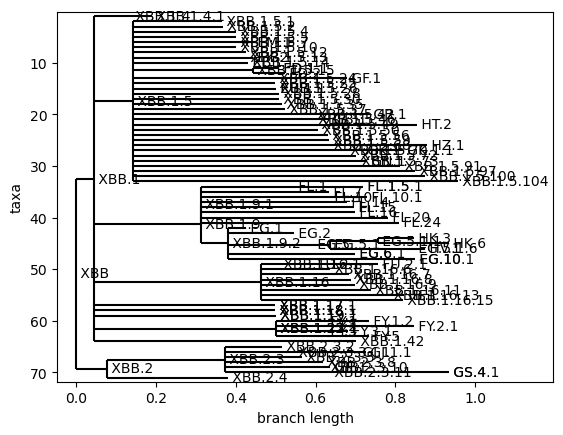

In [45]:
def date_str_to_year(date_str):
    dt = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    # https://stackoverflow.com/a/29852163
    year_start = datetime.datetime(dt.year, 1, 1)
    year_end = year_start.replace(year=dt.year+1)
    return dt.year + ((dt - year_start).total_seconds() /  # seconds so far
        float((year_end - year_start).total_seconds()))  # seconds in year
    
def build_clade(pango_name, parent_date):
    """Recursive function to build clades."""
    clade_date = date_str_to_year(pango_clades[pango_name]["designationDate"])
    assert clade_date >= parent_date
    return Bio.Phylo.BaseTree.Clade(
        name=pango_name,
        clades=[build_clade(c, clade_date) for c in pango_clades[pango_name]["children"]],
        branch_length=clade_date - parent_date,
    )

pango_pair_dms_growth_dict = (
    pango_pair_dms_growth_df
    .query("n_sequences >= @min_sequences")
    .query("parent_n_sequences >= @min_sequences")
    .set_index("clade")
    [["parent", "spike_new_muts", "nonspike_new_muts", "growth_rate", "parent_growth_rate", *phenotypes]]
    .to_dict(orient="index")
)

clade_dms_growth_dict = (
    clade_growth_dms_df
    .query("n_sequences >= @min_sequences")
    .set_index("clade")
    [["growth_rate", *phenotypes]]
    .to_dict(orient="index")
)

for root_clade in starting_clades:
    print(f"Drawing clade for {root_clade}")

    # first build a tree of all clades
    root_date = date_str_to_year(pango_clades[root_clade]["designationDate"])
    tree = Bio.Phylo.BaseTree.Tree(build_clade(root_clade, root_date))
    print(f"Starting tree has {len(tree.get_terminals())=} and {len(tree.get_nonterminals())=}")

    # now prune all non-terminal nodes without growth and DMS data
    removed = True
    while removed:
        for tip in tree.get_terminals():
            if (
                (tip.name not in clade_dms_growth_dict)  # no growth data
                or (tip.name not in set(pango_pair_df["clade"]))  # no spike muts relative to parent
            ):
                parents = tree.get_path(tip)
                if len(parents) == 1:
                    parent = tree.root
                else:
                    parent = tree.get_path(tip)[-2]
                assert tip in parent.clades
                parent.clades = [c for c in parent.clades if c != tip]
                break
        else:
            removed = False
    print(f"After pruning for tips with DMS and growth data, {len(tree.get_terminals())=} and {len(tree.get_nonterminals())=}")

    Bio.Phylo.draw(tree)
        

In [46]:
Bio.Phylo.draw?

Signature:
Bio.Phylo.draw(
    tree,
    label_func=<class 'str'>,
    do_show=True,
    show_confidence=True,
    axes=None,
    branch_labels=None,
    label_colors=None,
    *args,
    **kwargs,
)
Docstring:
Plot the given tree using matplotlib (or pylab).

The graphic is a rooted tree, drawn with roughly the same algorithm as
draw_ascii.

Additional keyword arguments passed into this function are used as pyplot
options. The input format should be in the form of:
pyplot_option_name=(tuple), pyplot_option_name=(tuple, dict), or
pyplot_option_name=(dict).

Example using the pyplot options 'axhspan' and 'axvline'::

    from Bio import Phylo, AlignIO
    from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
    constructor = DistanceTreeConstructor()
    aln = AlignIO.read(open('TreeConstruction/msa.phy'), 'phylip')
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(aln)
    tree = constructor.upgma(dm)
    Phylo.draw(tree, axh

In [29]:
pango_clades["XBB"]["designationDate"]

'2022-09-17'

In [34]:
dt.year + (dt - dt.year)

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'int'